In [21]:
import warnings
import pandas as pd
import numpy as np
import pandas_profiling
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
%matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion

In [22]:
bureau_balance = pd.read_csv(r"D:\Downloads\NEU\NAM 3 KI 1\Visualization\GITHUB FINAL PROJECT\Credit-Risk-Analysis\dseb-63-data-preparation-final-project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_bureau_balance.csv")
bureau_balance_profile = bureau_balance.profile_report(title="Bureau balance dataset report")
bureau_balance_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Observation from the report
- The shape of bureau_balance.csv is (27299925, 3)
- The number of missing values in bureau_balance.csv is 0
- The number of duplicate values in bureau_balance.csv is 0
-This table contains the monthly status for each of the previous loan for a particular applicant reported by the Credit Bureau Department.
There are 8 unique values for the STATUS which are encoded. Each of them have a special meaning. 
C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off.
- The most earliest month's balance that we have is the 96 months back status, i.e. the Status has been provided upto 8 years of history for loans for which those exist.

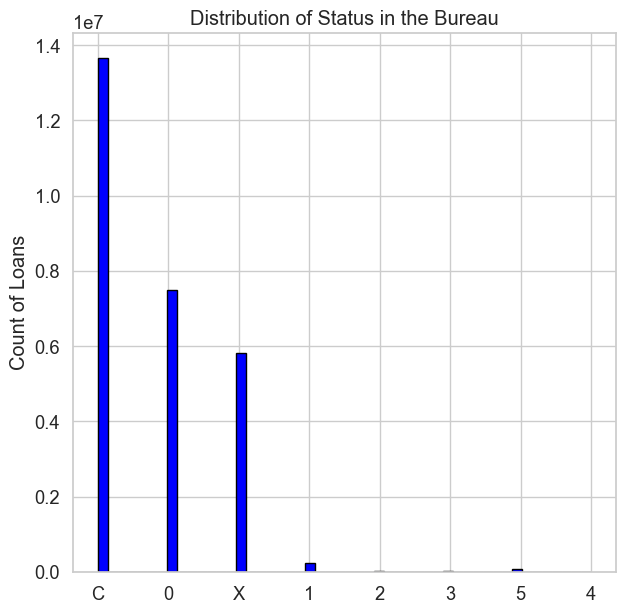

In [23]:
plt.figure(figsize=(7, 7))
plt.hist(bureau_balance['STATUS'].values, bins=50, edgecolor='black', color='blue')
plt.ylabel('Count of Loans')
plt.title('Distribution of Status in the Bureau')

plt.show()

- Most of the loans are Closed in the Credit Bureau, which is followed by clients with 0 DPD and then by applicants whose status is unknown.
- We can conclude that there are very few annuity defaulters in the data.

In [24]:
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


# Understanding of variables
SK_BUREAU_ID - Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table

MONTHS_BALANCE - Month of balance relative to application date (-1 means the freshest balance date)

STATUS - Status of Credit Bureau loan during the month (active, closed, DPD0-30,… [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off ] )

In [25]:
def plot_categorical_variables_bar(data, column_name, figsize = (18,6), percentage_display = True, plot_defaulter = True, rotation = 0, horizontal_adjust = 0, fontsize_percent = 'xx-small'):
    '''
    Function to plot Categorical Variables Bar Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display
        
    '''
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)
    plt.show()

In [26]:
def plot_continuous_variables(data, column_name, plots=['distplot', 'countplot', 'box'], scale_limits=None, figsize=(20, 8), histogram=True, log_scale=False):
    '''
    Plot distribution of continuous variables.

    Parameters:
    - data: DataFrame
        The DataFrame containing the data.
    - column_name: str
        The name of the column whose distribution is to be plotted.
    - plots: list, default=['distplot', 'countplot', 'box']
        List of plots to generate for the continuous variable.
    - scale_limits: tuple (left, right), default=None
        Control the limits of values to be plotted in case of outliers.
    - figsize: tuple, default=(20, 8)
        Size of the figure to be plotted.
    - histogram: bool, default=True
        Whether to plot histogram along with distplot or not.
    - log_scale: bool, default=False
        Whether to use log-scale for variables with outlying points.
    '''
    data_to_plot = data.copy()
    if scale_limits:
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize=figsize)
    sns.set_style('whitegrid')

    for i, plot_type in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)

        if plot_type == 'distplot':
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist=False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist=False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        elif plot_type == 'box':
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        elif plot_type == 'countplot':
            sns.countplot(x=column_name, hue='TARGET', data=data_to_plot)
            plt.title("Count-Plot of {}".format(column_name))

    plt.show()


# EDA

## MERGE with TARGET columns in application_train.csv to get more insights

In [27]:
bureau = pd.read_csv(r"D:\Downloads\NEU\NAM 3 KI 1\Visualization\GITHUB FINAL PROJECT\Credit-Risk-Analysis\dseb-63-data-preparation-final-project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_bureau.csv")
bureau

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR
0,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,254629
1,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,254629
2,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,254629
3,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,254629
4,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,254629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465320,5052629,Closed,currency 1,-532,0,45.0,-227.0,NaN,0,450000.0,0.0,0.0,0.0,Consumer credit,-31,NaN,66820
1465321,5054382,Closed,currency 1,-381,0,-199.0,-199.0,0.0,0,19800.0,0.0,0.0,0.0,Consumer credit,-199,0.0,166221
1465322,5043236,Active,currency 1,-1441,0,2197.0,NaN,NaN,0,1800000.0,1076809.5,0.0,0.0,Mortgage,-2,NaN,118290
1465323,5053303,Closed,currency 1,-375,0,-41.0,-19.0,NaN,0,175054.5,NaN,NaN,0.0,Consumer credit,-4,17140.5,95296


In [28]:
application_train = pd.read_csv(r"D:\Downloads\NEU\NAM 3 KI 1\Visualization\GITHUB FINAL PROJECT\Credit-Risk-Analysis\dseb-63-data-preparation-final-project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_train.csv")
application_train.head()

,Unnamed: 0,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_CURR
0,0,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,278621
1,1,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,139008
2,2,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,138348
3,3,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,64140
4,4,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,219374


In [29]:
data_merged_prev = pd.merge(bureau[['SK_ID_CURR','SK_ID_BUREAU']], bureau_balance, how= 'left', on=['SK_ID_BUREAU'])
data_merged_prev

,SK_ID_CURR,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,254629,5714462,NaN,NaN
1,254629,5714463,NaN,NaN
2,254629,5714464,NaN,NaN
3,254629,5714465,NaN,NaN
4,254629,5714466,NaN,NaN
...,...,...,...,...
15643417,139955,5053356,-85.0,0
15643418,139955,5053356,-86.0,0
15643419,139955,5053356,-87.0,0
15643420,139955,5053356,-88.0,0


In [30]:
data_merged = pd.merge(application_train[["SK_ID_CURR", "TARGET"]], data_merged_prev, how='left', on=['SK_ID_CURR'])
data_merged

,SK_ID_CURR,TARGET,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,278621,0,5885877.0,NaN,NaN
1,278621,0,5885878.0,NaN,NaN
2,278621,0,5885879.0,NaN,NaN
3,278621,0,5885880.0,NaN,NaN
4,139008,0,NaN,NaN,NaN
...,...,...,...,...,...
12559521,258328,0,5126337.0,-72.0,C
12559522,258328,0,5126337.0,-73.0,C
12559523,258328,0,5126337.0,-74.0,C
12559524,258328,0,5126337.0,-75.0,0


## Months_balance

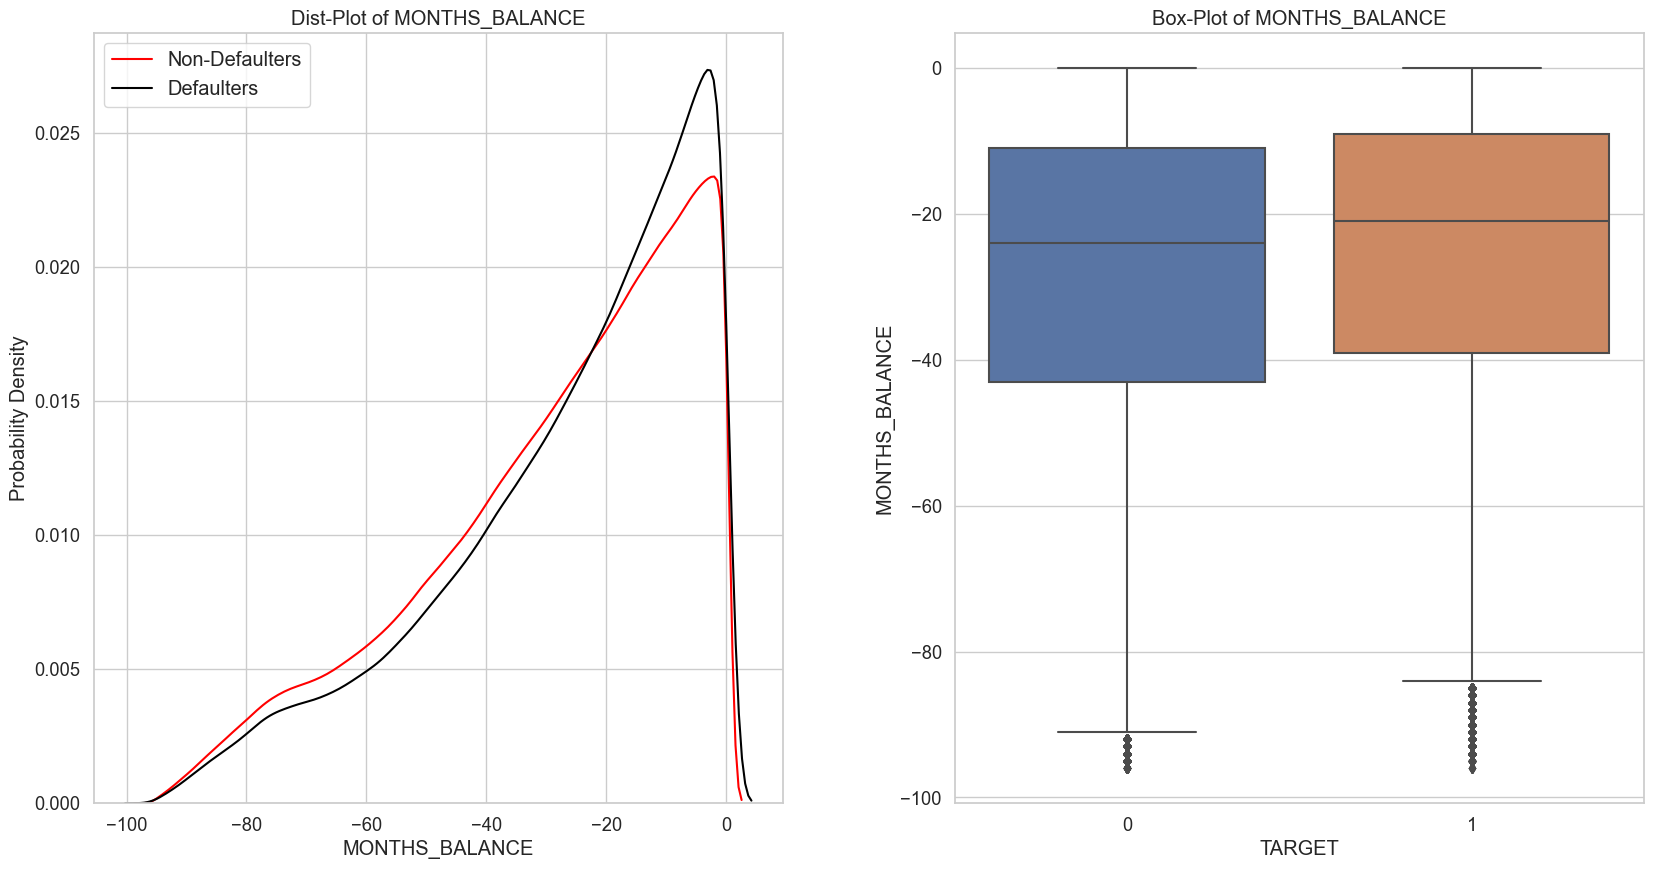

In [31]:
plot_continuous_variables(data_merged, 'MONTHS_BALANCE', plots=['distplot','box'], figsize=(20,10))

Total Number of unique categories of STATUS = 9


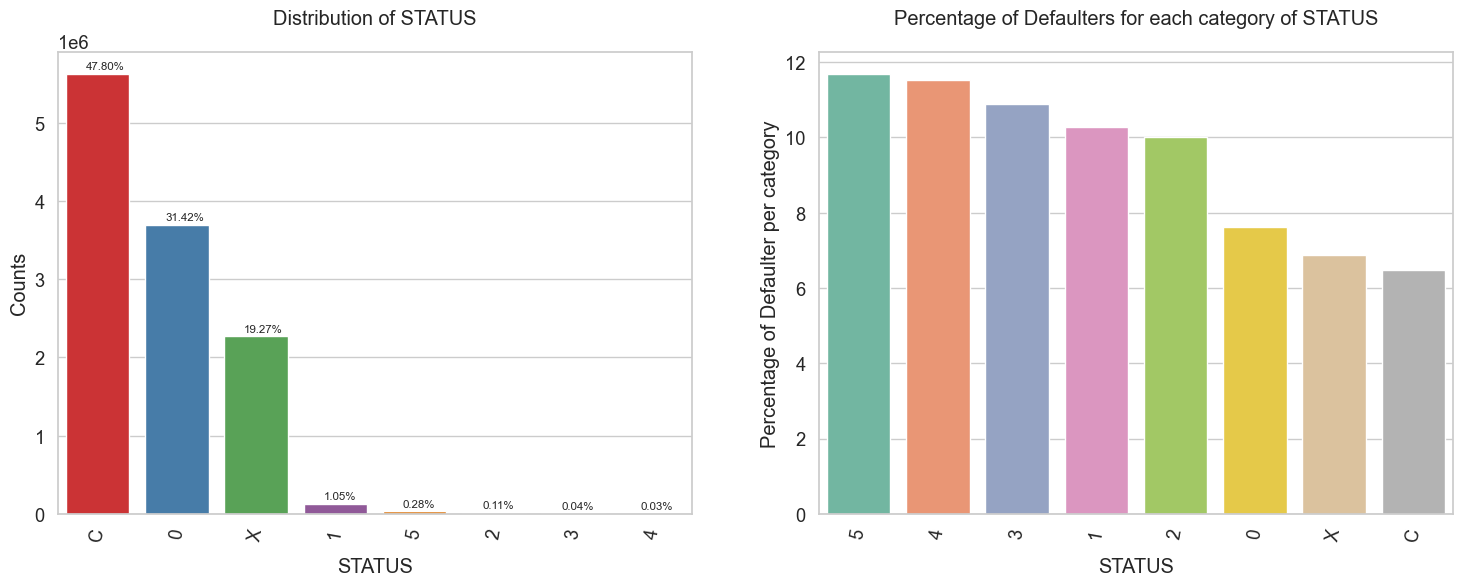

In [32]:
plot_categorical_variables_bar(data_merged,'STATUS',rotation=80, horizontal_adjust=0.25 )

Có 13.646.993 các khoản nợ có tình trang đã đóng còn lại, gần 7.500.000 các khoản nợ là không được thanh toán theo lịch đã sắp xếp và phải chịu phí trễ hạn, và có hơn 5.800.000 các khoản nợ là vẫn chưa xác định rõ được tình trạng.

## Số lượng STATUS của mỗi khách hàng

In [33]:
grp = data_merged[['SK_ID_CURR', 'STATUS', 'TARGET']].groupby(['SK_ID_CURR','TARGET'])['STATUS'].nunique().reset_index()
grp

,SK_ID_CURR,TARGET,STATUS
0,0,0,0
1,1,1,2
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
246004,307505,0,2
246005,307506,0,0
246006,307507,0,0
246007,307509,0,3


In [34]:
grp = grp[grp['STATUS'] != 0]
grp

,SK_ID_CURR,TARGET,STATUS
1,1,1,2
7,8,1,7
10,11,0,4
16,20,0,3
17,21,0,4
...,...,...,...
245995,307494,0,3
245997,307496,0,2
246000,307501,0,3
246004,307505,0,2


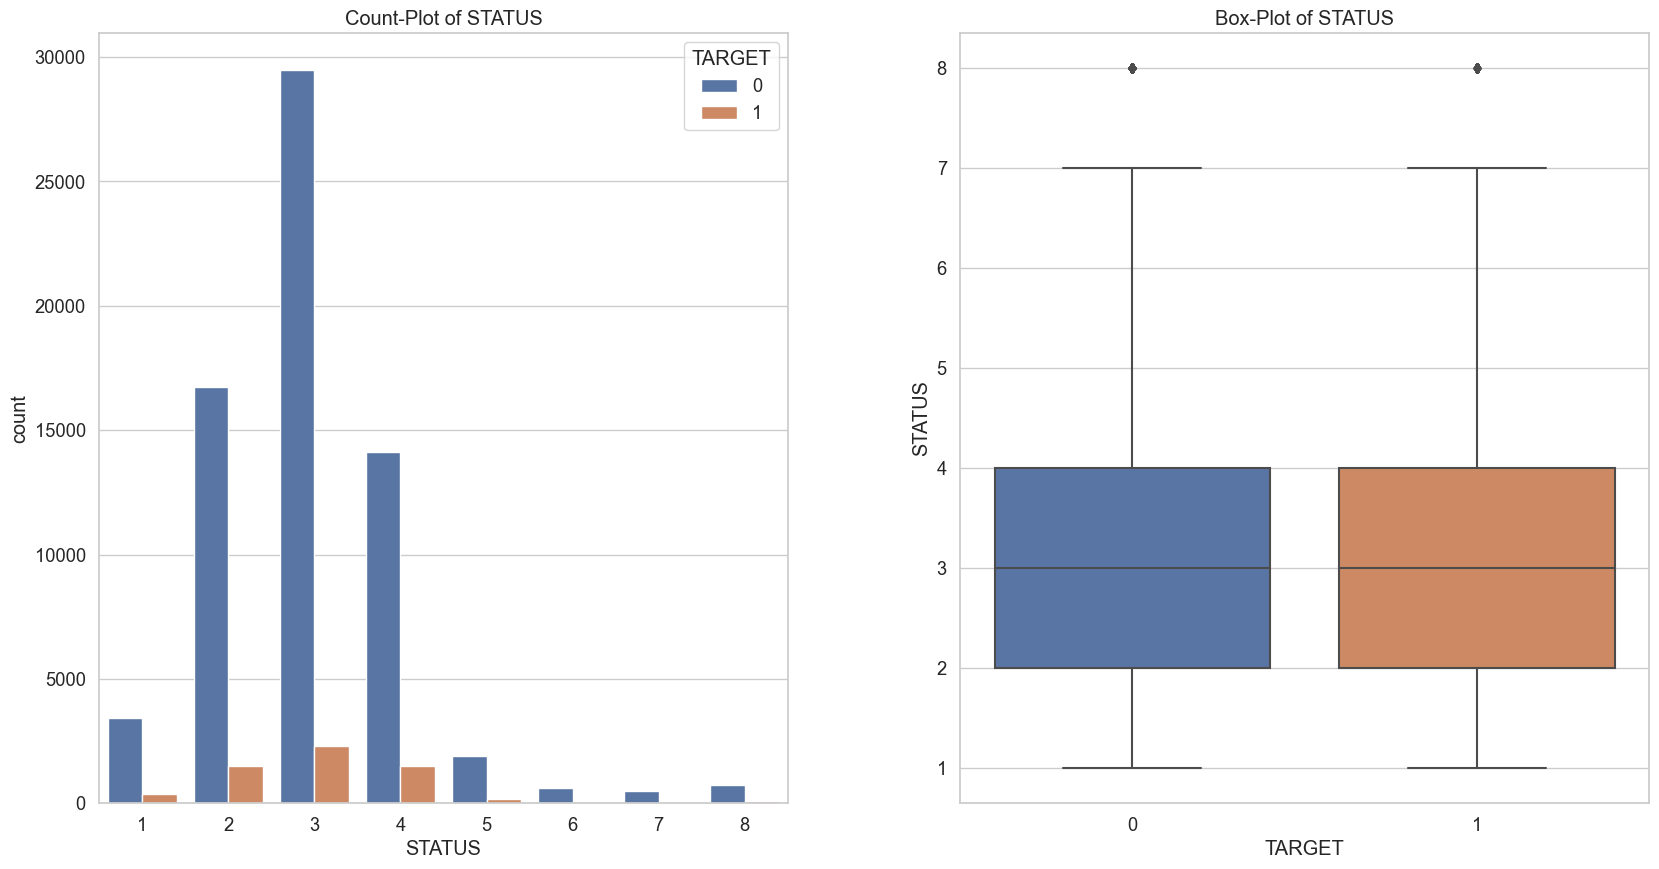

In [35]:
plot_continuous_variables(grp, 'STATUS', plots=['countplot', 'box'], figsize=(20, 10))


Yếu tố số lượng các status không ảnh hưởng đến việc khách hàng có gặp khó khăn trong việc trả nợ hay không vì phân bố rất giống nhau